In [1]:
!pip install -q -U lightautoml catboost lightgbm xgboost

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
beatrix-jupyterlab 2023.128.151533 requires jupyterlab~=3.6.0, but you have jupyterlab 4.1.6 which is incompatible.
dask-expr 1.0.11 requires pandas>=2, but you have pandas 1.5.3 which is incompatible.
featuretools 1.30.0 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.
fitter 1.7.0 requires joblib<2.0.0,>=1.3.1, but you have joblib 1.2.0 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
mizani 0.11.1 requires pandas>=2.1.0, but you have pandas 1.5.3 which is incompatible.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatib

In [2]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
import pandas as pd
import numpy as np
import torch

In [3]:
TARGET_NAME = 'FloodProbability'
TEST_SIZE = 0.1
N_THREADS = 4
TIMEOUT = 3600 * 11
N_FOLDS = 5
SEED = 27

In [4]:
np.random.seed(SEED)
torch.set_num_threads(N_THREADS)

In [5]:
feats_to_drop = [
    '_sum_log', '_mean', '_median', '_max', '_min', '_var', '_mode', 
    '_25th', '_75th', '_hmean', '_gmean',
    '_2nd_moment', '_3rd_moment', '_entropy', '_sort_0',
    '_sort_1', '_sort_2', '_sort_3', '_sort_4', '_sort_5', '_sort_6',
    '_sort_7', '_sort_8', '_sort_9', '_sort_10', '_sort_11', '_sort_12',
    '_sort_13', '_sort_14', '_sort_15', '_sort_16', '_sort_17', '_sort_18',
    '_sort_19'
]

train = pd.read_csv('/kaggle/input/flood-prediction-precomputed-stat-features/train.csv', index_col='id')
train = train.drop(columns=feats_to_drop)

_train, _val = train_test_split(
    train,
    test_size=TEST_SIZE,
    random_state=SEED
)
del train

# Training

In [6]:
task = Task(
    name='reg',
    loss='mse',
    metric='r2',
    greater_is_better=True
)

In [7]:
automl = TabularAutoML(
    task=task,
    timeout=TIMEOUT,
    cpu_limit=N_THREADS,
    reader_params={
        'n_jobs': N_THREADS,
        'cv':  N_FOLDS,
        'random_state': SEED
    },
    tuning_params = {'max_tuning_time': 1800},
)

oof_preds = automl.fit_predict(
    _train,
    roles={'target': TARGET_NAME},
    verbose=1
)

[06:22:25] Stdout logging level is INFO.
[06:22:25] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[06:22:25] Task: reg

[06:22:25] Start automl preset with listed constraints:
[06:22:25] - time: 39600.00 seconds
[06:22:25] - CPU: 4 cores
[06:22:25] - memory: 16 GB

[06:22:25] Train data shape: (1006161, 56)



/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:37: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


[06:22:44] Layer 1 train process start. Time left 39581.00 secs
[06:22:47] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[06:22:55] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.8507502534692922
[06:22:55] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[06:22:55] Time left 39570.19 secs

[06:24:18] Selector_LightGBM fitting and predicting completed
[06:24:19] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[06:31:12] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.8688893661217516
[06:31:12] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[06:31:12] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 1800.00 secs
[07:01:57] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[07:01:57] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[07:05:31] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8691071670382547
[07:05:31] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting an

In [8]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.27797 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.72203 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) 


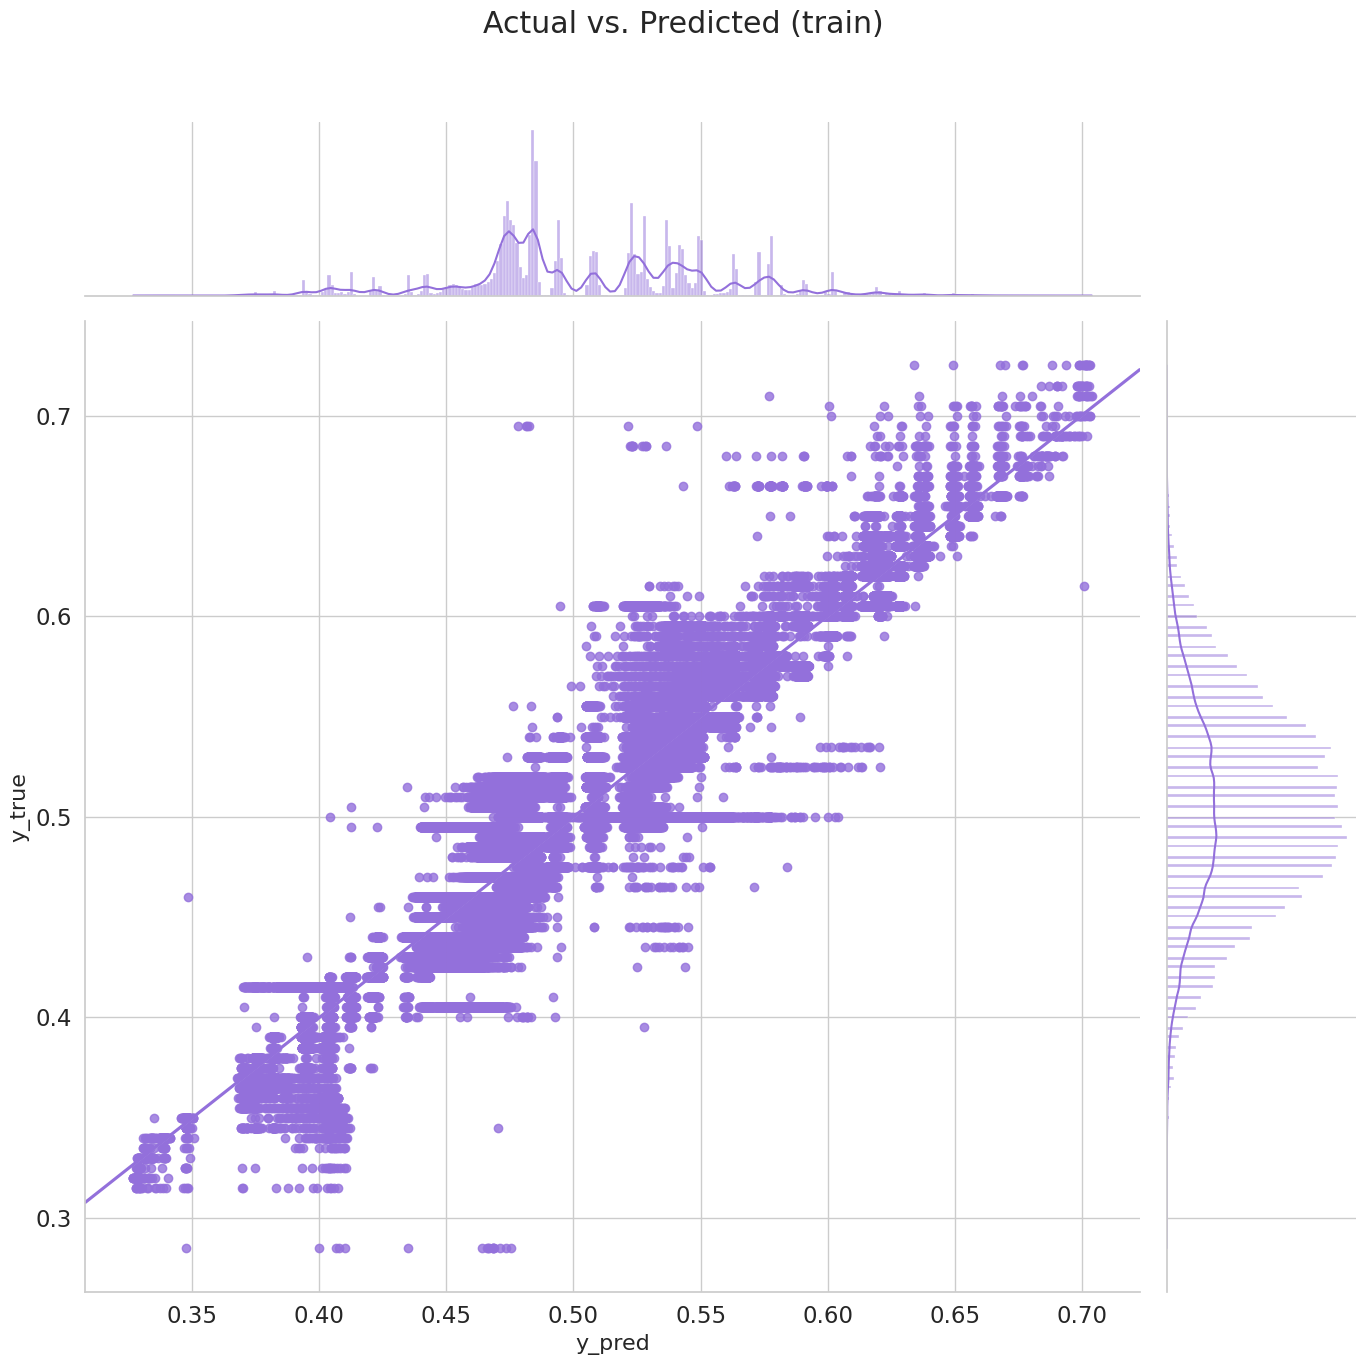

In [9]:
sns.set(style="whitegrid", font_scale=1.5)
g = sns.jointplot(
    x=oof_preds.data[:, 0],
    y=_train[TARGET_NAME],
    kind="reg",
    truncate=False,
    color='#9370DB',
    height=14,
)
g.set_axis_labels('y_pred', 'y_true', fontsize=16)
g.fig.suptitle("Actual vs. Predicted (train)")
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.9)

# Evaluating The Model on the Validation Set

In [10]:
X_val = _val.drop(columns=[TARGET_NAME])
y_val = _val[TARGET_NAME].values

y_preds = automl.predict(X_val).data[:, 0]

score = r2_score(y_val, y_preds)

print(f'R2 score: {score}')

R2 score: 0.869295767825248


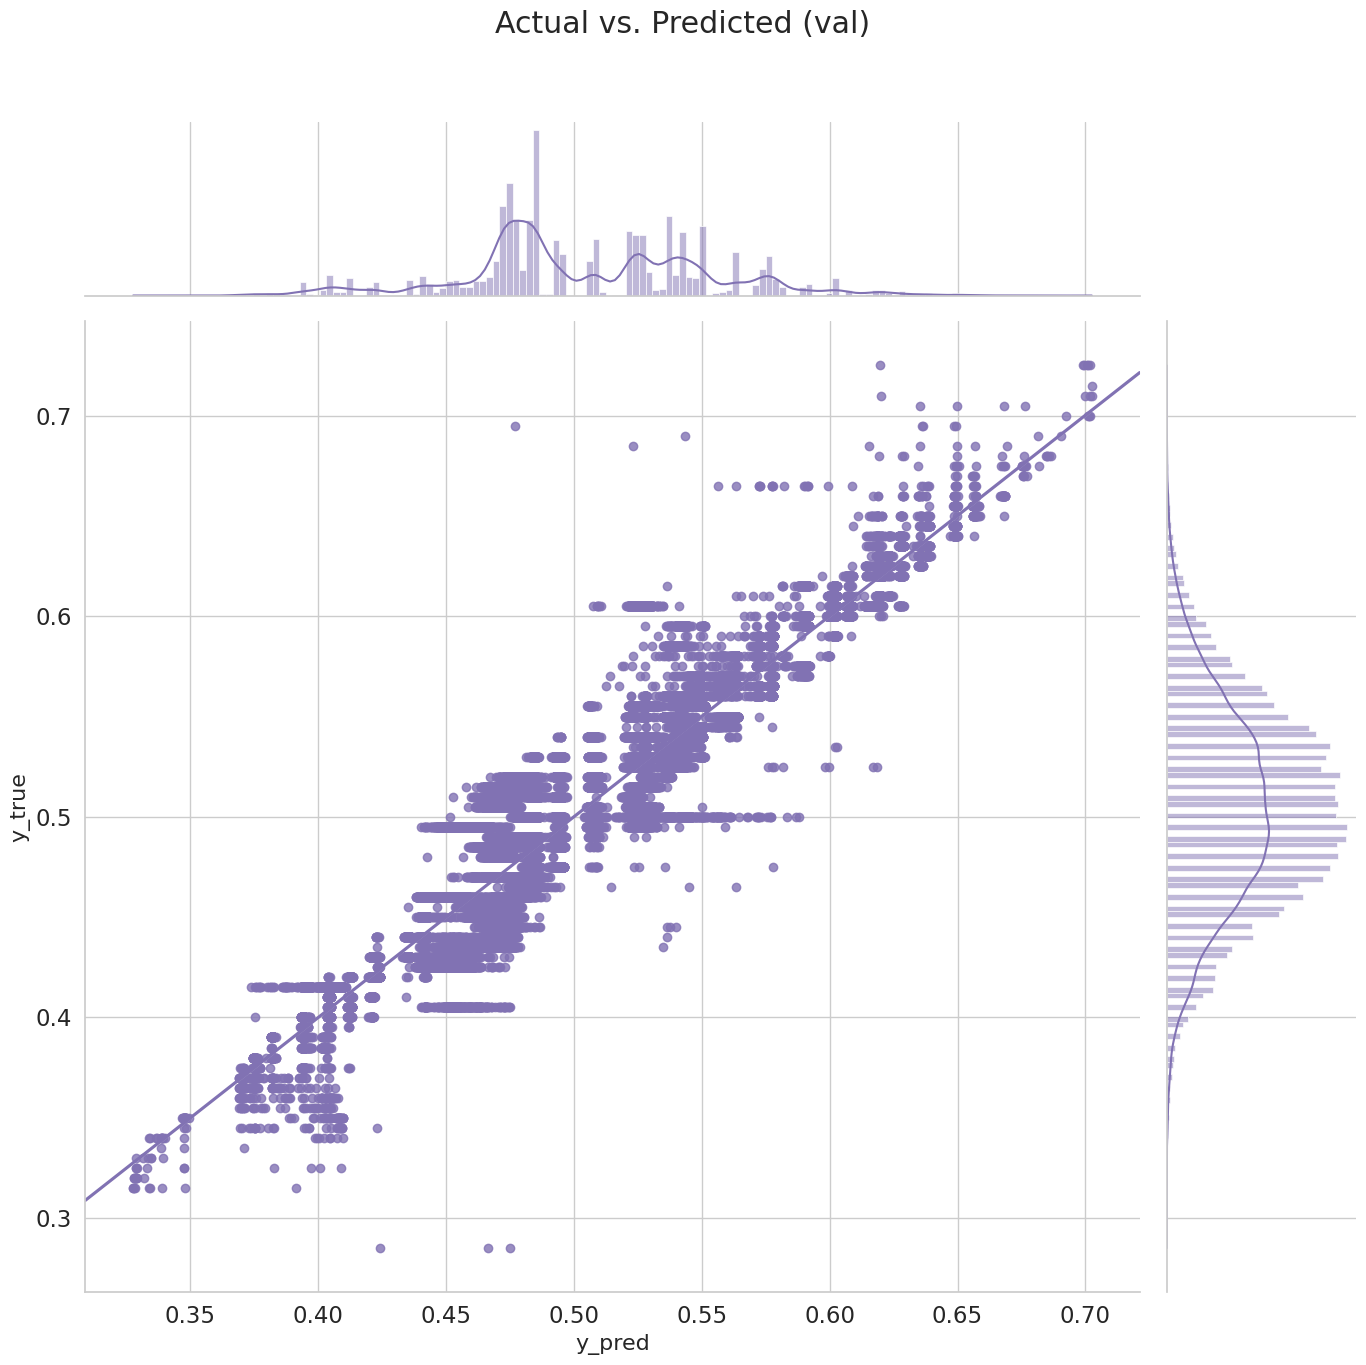

In [11]:
sns.set(style="whitegrid", font_scale=1.5)
g = sns.jointplot(
    x=y_preds,
    y=y_val,
    kind="reg",
    truncate=False,
    color='m',
    height=14,
)
g.set_axis_labels('y_pred', 'y_true', fontsize=16)
g.fig.suptitle("Actual vs. Predicted (val)")
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.9)

# Making Predictions and Creating a Submission File

In [12]:
test = pd.read_csv('/kaggle/input/flood-prediction-precomputed-stat-features/test.csv', index_col='id')
test = test.drop(columns=feats_to_drop)

test_preds = automl.predict(test)

submission = pd.DataFrame({'id': test.index, 'FloodProbability': test_preds.data[:, 0]})
submission.to_csv('submission.csv', index=False)
submission.head()

,id,FloodProbability
0,1117957,0.577465
1,1117958,0.455675
2,1117959,0.449226
3,1117960,0.466970
4,1117961,0.466876
